In [1]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model

import numpy as np

from IPython.display import Image

In [2]:
# Scaling is it required with tensorflow gen?
# change the error to something else like similarity index
# take a part of the image as input and provide SR for that part only

In [3]:
train_hr_directory = './../dataset/train_dataset/HR/'
train_lr_directory = './../dataset/train_dataset/LR/'

valid_hr_directory = './../dataset/valid_dataset/HR/'
valid_lr_directory = './../dataset/valid_dataset/LR/'

In [4]:
def rescale(image):
    return image / 255.0

In [5]:
train_img_lr = image_dataset_from_directory(
    train_lr_directory,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=8,
    image_size=(350, 350),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='lanczos5',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

train_img_lr = train_img_lr.map(rescale)

Found 3450 files belonging to 1 classes.


In [6]:
train_img_hr = image_dataset_from_directory(
    train_hr_directory,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=8,
    image_size=(700, 700),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='lanczos5',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

train_img_hr = train_img_hr.map(rescale)

Found 3450 files belonging to 1 classes.


In [7]:
# train_img_lr = image_dataset_from_directory(
#     train_lr_directory,
#     label_mode=None,
#     class_names=None,
#     color_mode='rgb',
#     batch_size=16,
#     image_size=(300, 300),
#     shuffle=False,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation='bilinear',
#     follow_links=False,
#     crop_to_aspect_ratio=False,
# )

In [8]:
# image_batch_hr = next(iter(train_img_hr))

# image_batch_lr = next(iter(train_img_lr))

In [9]:
# image_batch_hr[3]

In [10]:
# tf.keras.preprocessing.image.array_to_img(image_batch_hr[3]*255)

In [11]:
# tf.keras.preprocessing.image.array_to_img(image_batch_lr[3])

In [12]:
def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    """Creates an EDSR model."""
    x_in = Input(shape=(None, None, 3))
    x = b = Conv2D(num_filters, 3, padding='same')(x_in)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)

    return Model(x_in, x, name="edsr")

def res_block(x_in, filters, scaling):
    """Creates an EDSR residual block."""
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x

def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        """Sub-pixel convolution."""
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return PixelShuffle(scale=factor)(x)

    if scale > 2:
        x = upsample_1(x, 2, name='upsample_1')
        x = upsample_1(x, 2, name='upsample_2')
    else:
        x = upsample_1(x, scale, name='upsample_1')

    return x


class PixelShuffle(tf.keras.layers.Layer):
    def __init__(self, scale, **kwargs):
        super(PixelShuffle, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def get_config(self):
        config = super(PixelShuffle, self).get_config()
        config.update({"scale": self.scale})
        return config



In [13]:

# Create a single dataset with (input, target) pairs
# train_dataset = tf.data.Dataset.zip((list(train_img_lr.as_numpy_iterator()), list(train_img_hr.as_numpy_iterator())))

train_dataset = tf.data.Dataset.zip((train_img_lr, train_img_hr))

In [14]:
# def combined_loss(alpha=0.9):
#     def loss(y_true, y_pred):
#         mse = tf.reduce_mean(tf.square(y_true - y_pred))
#         ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)
#         return alpha * (1.0 - ssim) + (1.0 - alpha) * mse
#     return loss

def combined_loss():
    def loss(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)
        return mse
    return loss

In [18]:
# Create the EDSR model.
model = edsr(scale=2, num_filters=60, num_res_blocks=6, res_block_scaling=None)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=combined_loss())
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='mean_squared_error') 

In [19]:
model.summary()

Model: "edsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, None, None, 6 1680        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 6 32460       conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, None, None, 6 32460       conv2d_16[0][0]                  
_______________________________________________________________________________________________

In [22]:
# epochs - 110
# Now you can train your model
model.fit(train_dataset, epochs=30)

Epoch 1/30
432/432 [==============================] - 2674s 6s/step - loss: 0.0038
Epoch 2/30
432/432 [==============================] - 1066s 2s/step - loss: 0.0038
Epoch 3/30
432/432 [==============================] - 467s 1s/step - loss: 0.0038
Epoch 4/30
432/432 [==============================] - 472s 1s/step - loss: 0.0037
Epoch 5/30
432/432 [==============================] - 472s 1s/step - loss: 0.0036
Epoch 6/30
432/432 [==============================] - 473s 1s/step - loss: 0.0036
Epoch 7/30
432/432 [==============================] - 473s 1s/step - loss: 0.0035
Epoch 8/30
432/432 [==============================] - 473s 1s/step - loss: 0.0035
Epoch 9/30
432/432 [==============================] - 470s 1s/step - loss: 0.0098
Epoch 10/30
432/432 [==============================] - 469s 1s/step - loss: 0.0044
Epoch 11/30
432/432 [==============================] - 469s 1s/step - loss: 0.0042
Epoch 12/30
432/432 [==============================] - 469s 1s/step - loss: 0.0041
Epoch 13/30

In [18]:
model.save("edsr_fullimage_sr_model_v3.h5")

c:\Users\Ashwin RK\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


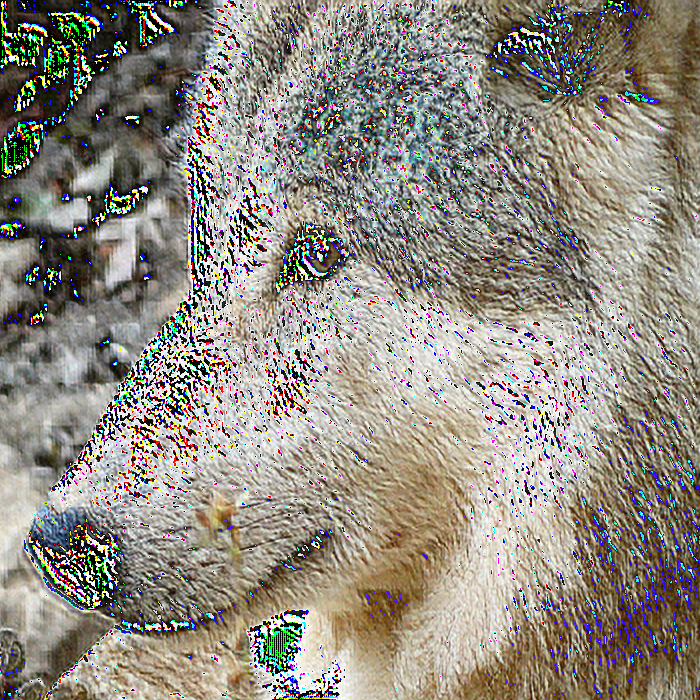

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the image
img = load_img('./../dataset/valid_dataset/LR/Div2k/0805x4.png', target_size=(350, 350))

# Convert the image to a numpy array
img_array = img_to_array(img)

img_array = img_array / 255.0

# Add an extra dimension to match the batch shape expected by the model
img_array = np.expand_dims(img_array, axis=0)

# Make a prediction
prediction = model.predict(img_array)

# Remove the extra dimension
prediction = np.squeeze(prediction, axis=0)

# Rescale the pixel values
prediction = prediction * 255.0


# Convert to an integer type
prediction = prediction.astype(np.uint8)

tf.keras.preprocessing.image.array_to_img(prediction)

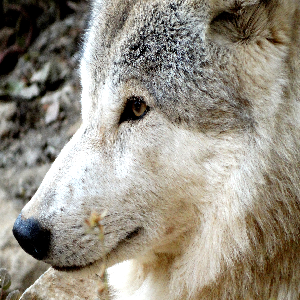

In [40]:
load_img('./../dataset/valid_dataset/HR/Div2K_hR/0805.png', target_size=(300, 300))

In [ ]:
model.save